### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import preprocess.view_utils as view_utils

In [3]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
import skimage.io as io
import openslide

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Generate Dataframe with all data info

In [6]:
if environ.get('LVSC_DATA_PATH') is not None:
    PAIP2020_DATA_PATH = environ.get('PAIP2020_DATA_PATH')
else:
    print("Please set the environment variable PAIP2020_DATA_PATH. Read the README!")

In [7]:
msi_h_prediction = pd.read_csv(PAIP2020_DATA_PATH + "Train/annotation/traning_data_MSI.csv")
msi_h_prediction.head()

,WSI_ID,MSI-H Prediction
0,training_data_01,1
1,training_data_02,0
2,training_data_03,0
3,training_data_04,0
4,training_data_05,1


In [8]:
total_cases = 47

In [9]:
validation_frac = 0.15
validation_samples = np.zeros(total_cases)
validation_samples[:int(total_cases*validation_frac)] = 1
np.random.seed(42)
np.random.shuffle(validation_samples)

In [10]:
train_info = []
rootdir = PAIP2020_DATA_PATH + "Train/WSI"
indx = 0
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith(".svs") or file.endswith(".SVS"):
            relative_path_wsi = "Train/WSI/" + file
            relative_path_annotation = "Train/annotation/" + file[:-4] + ".xml"
            relative_path_annotation_tif = "Train/mask_img_l2/" + file[:-4] + "_l2_annotation_tumor.tif"
            is_valid = choices([0, 1], [0.85, 0.15])[0]
            
            train_info.append({
                "case":relative_path_wsi.split("/")[-1][:-4],
                "wsi":relative_path_wsi, 
                "annotation":relative_path_annotation, 
                "annotation_tif":relative_path_annotation_tif, 
                "MSI-H": msi_h_prediction.loc[msi_h_prediction["WSI_ID"]==file[:-4]]["MSI-H Prediction"].iloc[0],
                "is_validation":validation_samples[indx]
            })
            
            indx+=1
            
train_info = pd.DataFrame(train_info)
train_info.is_validation = train_info.is_validation.astype("int8")
train_info.head()

,case,wsi,annotation,annotation_tif,MSI-H,is_validation
0,training_data_41,Train/WSI/training_data_41.svs,Train/annotation/training_data_41.xml,Train/mask_img_l2/training_data_41_l2_annotati...,0,0
1,training_data_38,Train/WSI/training_data_38.svs,Train/annotation/training_data_38.xml,Train/mask_img_l2/training_data_38_l2_annotati...,0,0
2,training_data_36,Train/WSI/training_data_36.svs,Train/annotation/training_data_36.xml,Train/mask_img_l2/training_data_36_l2_annotati...,0,0
3,training_data_10,Train/WSI/training_data_10.svs,Train/annotation/training_data_10.xml,Train/mask_img_l2/training_data_10_l2_annotati...,0,0
4,training_data_08,Train/WSI/training_data_08.svs,Train/annotation/training_data_08.xml,Train/mask_img_l2/training_data_08_l2_annotati...,0,0


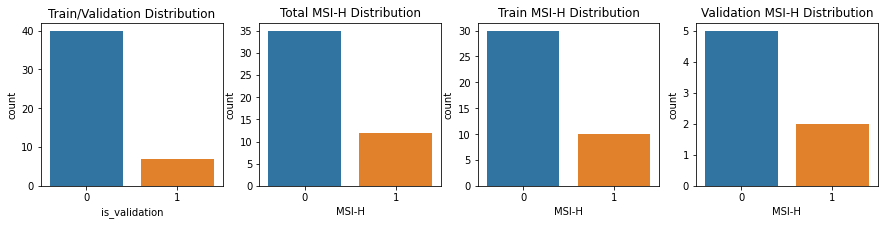

In [11]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15,3))
#ax1.axis('off'); ax2.axis('off'); ax3.axis('off');
ax0.title.set_text('Train/Validation Distribution')
sns.countplot(train_info["is_validation"], ax=ax0)
ax1.title.set_text('Total MSI-H Distribution')
sns.countplot(train_info["MSI-H"], ax=ax1)
ax2.title.set_text('Train MSI-H Distribution')
sns.countplot(train_info.loc[train_info["is_validation"]==0]["MSI-H"], ax=ax2)
ax3.title.set_text('Validation MSI-H Distribution')
sns.countplot(train_info.loc[train_info["is_validation"]==1]["MSI-H"], ax=ax3)

In [12]:
os.makedirs("../utils/data", exist_ok=True)

In [13]:
train_info.to_csv("../utils/data/train.csv", index=False)

### Explore dataset

#### Load Mask

In [14]:
mask_example = PAIP2020_DATA_PATH + train_info.iloc[0]["annotation_tif"]
mask = view_utils.mask_loader(mask_example, verbose=True)

mask shape: (5816, 7594)


#### Load Whole Image Slide

In [15]:
DISPLAY_LEVEL=2
svs_example = PAIP2020_DATA_PATH + train_info.iloc[0]["wsi"]

In [16]:
wsi_head = openslide.OpenSlide(svs_example)
print("Level dimensions: {}".format(wsi_head.level_dimensions))

Level dimensions: ((121512, 93068), (30378, 23267), (7594, 5816), (3797, 2908))


In [17]:
new_size = (wsi_head.level_dimensions[DISPLAY_LEVEL][1], wsi_head.level_dimensions[DISPLAY_LEVEL][0])
print("New Size Level {}: {}".format(DISPLAY_LEVEL, new_size))

New Size Level 2: (5816, 7594)


In [18]:
slide_img = wsi_head.read_region((0, 0), DISPLAY_LEVEL, wsi_head.level_dimensions[DISPLAY_LEVEL])

In [19]:
full_slide_img = np.asarray(slide_img)[...,:3]
print("Full Slide Shape: {}".format(full_slide_img.shape))
print("Slide Info -> Max: {} / Min: {}".format(full_slide_img.max(), full_slide_img.min()))

Full Slide Shape: (5816, 7594, 3)
Slide Info -> Max: 255 / Min: 9


## Padding

In [20]:
import cv2

In [21]:
max_size = max(full_slide_img.shape[:2])

In [22]:
padded_array = np.zeros((max_size, max_size, 3)).astype(full_slide_img.dtype)

In [23]:
shape = np.shape(full_slide_img)
padded_array[:shape[0], :shape[1], :shape[2]] = full_slide_img

In [24]:
width, height = 512, 512
dim = (width, height)
resized = cv2.resize(padded_array, dim)

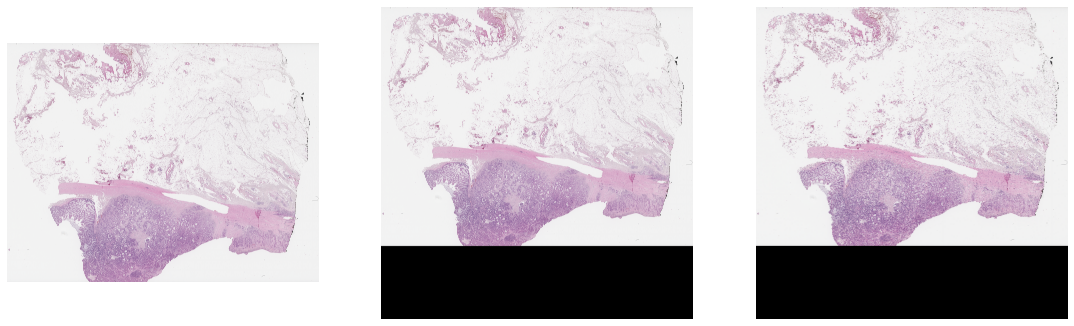

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(padded_array)
ax3.imshow(resized)

### Unpad

In [26]:
dim = (max_size, max_size)
unresized = cv2.resize(resized, dim, interpolation = cv2.INTER_AREA)

In [27]:
unpadded_array = np.zeros((full_slide_img.shape[0], full_slide_img.shape[1], 3)).astype(full_slide_img.dtype)

In [28]:
unpadded_array[:shape[0], :shape[1], :shape[2]] = full_slide_img

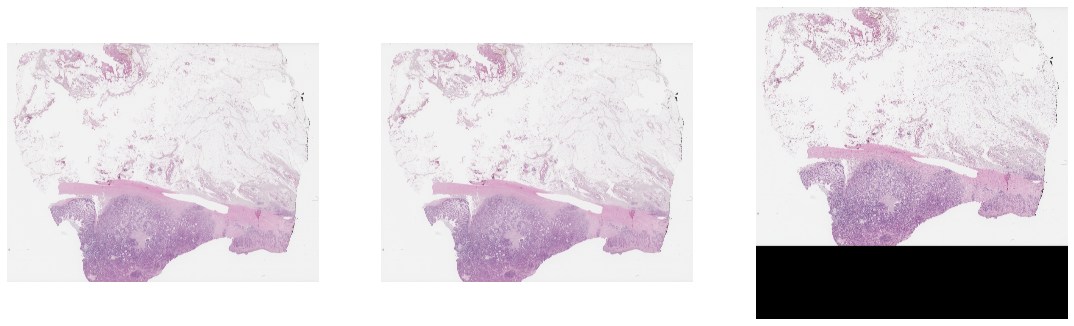

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(full_slide_img)
ax2.imshow(unpadded_array)
ax3.imshow(unresized)

### Loading generated

In [62]:
rootdir = PAIP2020_DATA_PATH + "Train/resized_level2_size512"
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if ".jpg" in file :
            relative_path = os.path.join("Train/resized_level2_size512/", file)
            absolute_path = os.path.join(rootdir, file)
            break

In [60]:
image = (io.imread(absolute_path)).astype(np.uint8)
mask = (io.imread(absolute_path[:-3]+"png")).astype(np.float32)

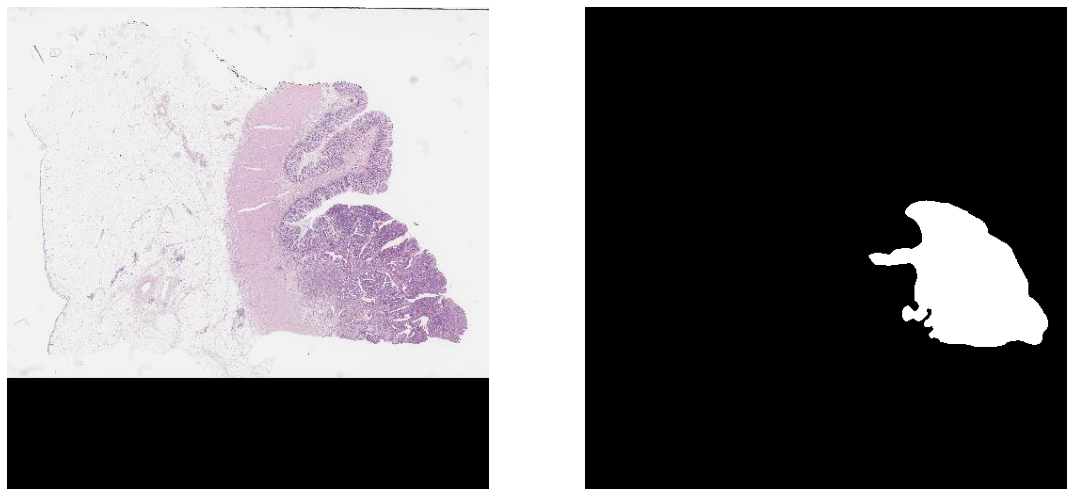

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 19))
ax1.axis('off'); ax2.axis('off')
ax1.imshow(image)
ax2.imshow(mask, cmap="gray")